In [1]:
import etl
import psycopg2
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import configparser
import os
import aws_util

pd.options.mode.chained_assignment = None  # default='warn'

# df_test = pd.DataFrame([datetime.now(), datetime.now()+timedelta(days=1)], columns=['date'])

config = configparser.ConfigParser()
config.read('dl.cfg')

['dl.cfg']

In [2]:
# conn = psycopg2.connect("host=127.0.0.1 dbname=covid19_db user=postgres password=localtest")
# cur = conn.cursor()

In [ ]:
db_name = 'covid19_db'
conn, cur = aws_util.conn_db(db_name)

## Plot case and vaccination together

#### Get confirmed cases from daily_case

In [3]:
case_sql = """
    SELECT date_string, Country_Region, sum(Confirmed) as country_confirmed
    FROM daily_case
    GROUP BY date_String, Country_Region
"""

df_confirmed = pd.read_sql(case_sql, conn)

In [4]:

mat_country_region_null = pd.isnull(df_confirmed['country_region'])
df_confimred = df_confirmed[~mat_country_region_null]


In [5]:
df_confirmed
# df_confirmed.dtypes

,date_string,country_region,country_confirmed
0,2020-01-22,Hong Kong,NaN
1,2020-01-22,Japan,2.0
2,2020-01-22,Macau,1.0
3,2020-01-22,Mainland China,547.0
4,2020-01-22,South Korea,1.0
...,...,...,...
73864,2021-04-05,Vietnam,2631.0
73865,2021-04-05,West Bank and Gaza,251288.0
73866,2021-04-05,Yemen,4798.0
73867,2021-04-05,Zambia,88930.0


#### get vaccination from vac

In [6]:
vac_sql = """
    SELECT *
    FROM vac
"""

df_vac = pd.read_sql(vac_sql, conn)

In [7]:
# df_vac

### get country/loc from country_loc

In [8]:
cl_sql = """
    SELECT *
    FROM country_loc
"""

df_cl = pd.read_sql(cl_sql, conn)

In [9]:
df_cl

,country_region,location,uid,iso2,iso3,code3,fips,admin2,province_state,combined_key,lat,long_,population,continent
0,Afghanistan,Afghanistan,4.0,AF,AFG,4.0,None,None,None,Afghanistan,33.939110,67.70995,38928341.0,Asia
1,Albania,Albania,8.0,AL,ALB,8.0,None,None,None,Albania,41.153300,20.16830,2877800.0,Europe
2,Algeria,Algeria,12.0,DZ,DZA,12.0,None,None,None,Algeria,28.033900,1.65960,43851043.0,Africa
3,Andorra,Andorra,20.0,AD,AND,20.0,None,None,None,Andorra,42.506300,1.52180,77265.0,Europe
4,Angola,Angola,24.0,AO,AGO,24.0,None,None,None,Angola,-11.202700,17.87390,32866268.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4171,US,United States,84056039.0,US,USA,840.0,56039.0,Teton,Wyoming,"Teton, Wyoming, US",43.935226,-110.58908,23464.0,North America
4172,US,United States,84056041.0,US,USA,840.0,56041.0,Uinta,Wyoming,"Uinta, Wyoming, US",41.287820,-110.54758,20226.0,North America
4173,US,United States,84056043.0,US,USA,840.0,56043.0,Washakie,Wyoming,"Washakie, Wyoming, US",43.904514,-107.68018,7805.0,North America
4174,US,United States,84056045.0,US,USA,840.0,56045.0,Weston,Wyoming,"Weston, Wyoming, US",43.839610,-104.56749,6927.0,North America


#### Join df_case with df_cl, then join df_vac

In [10]:
df_confirmed['country_region']

0                 Hong Kong
1                     Japan
2                     Macau
3            Mainland China
4               South Korea
                ...        
73864               Vietnam
73865    West Bank and Gaza
73866                 Yemen
73867                Zambia
73868              Zimbabwe
Name: country_region, Length: 73869, dtype: object

In [11]:
# Note that df_country_location can have several different Province_State for the same Country_Region.
# To get only the whole Country_Region and not the state granularity, need to filter by Province_State IS NULL

mat_prov_null = pd.isnull(df_cl['province_state'])
df_cl_for_comb = df_cl[mat_prov_null][['country_region', 'location', 'population', 'continent']]
df_confirmed_loc = df_confirmed.merge(df_cl_for_comb, on='country_region', how='left')

In [12]:
df_confirmed_loc_vac = df_confirmed_loc.merge(df_vac, on=['location', 'date_string'], how='left')

#### Join dim_table

### Analysis

In [13]:
list_vac_brands = df_vac['vaccine'].unique()

In [14]:
list_vac_brands

array(['Pfizer/BioNTech', 'Sputnik V', 'Oxford/AstraZeneca',
       'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V',
       'Oxford/AstraZeneca, Pfizer/BioNTech',
       'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech',
       'Pfizer/BioNTech, Sinopharm/Beijing', 'Sinovac',
       'Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Moderna, Pfizer/BioNTech', 'Oxford/AstraZeneca, Sinovac',
       'Sinopharm/Beijing', 'Pfizer/BioNTech, Sinovac',
       'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac', 'Moderna',
       'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Covaxin, Oxford/AstraZeneca',
       'Sinopharm/Beijing, Pfizer/ BioNTech',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sputnik V',
       'Sinopharm/Beijing, Sputnik V',
       'Oxford/AstraZeneca, Sinopharm/Beijing', 'Sputnik V, EpiVacCorona',
       'Johnson&Johnson',
       'Pfizer/BioNTech, Sinopharm/Bei

### Plotting

In [15]:
country = 'United Kingdom'

In [16]:
mat_us = df_confirmed_loc_vac['country_region'] == country
df_pd = df_confirmed_loc_vac[mat_us]

In [17]:
df_pd['date_datetime'] = df_pd['date_string'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [18]:
df_pd['daily_country_confirmed'] = df_pd.sort_values('date_datetime')['country_confirmed'].diff()
df_pd['daily_country_confirmed'] = df_pd['daily_country_confirmed'].fillna(0)

In [19]:
alpha_val=0.2
df_pd['daily_confirmed_ewm_mean'] = df_pd['daily_country_confirmed'].ewm(alpha=alpha_val).mean()

In [20]:
mat_outlier = (abs(df_pd['daily_country_confirmed']) > abs(2*df_pd['daily_confirmed_ewm_mean'])) & (abs(df_pd['daily_country_confirmed']) > 10000)
df_pd_do = df_pd[~mat_outlier]
# df_pd[mat_outlier]

In [21]:
df_pd_do['adjusted_people_vaccinated'] = (df_pd_do['people_fully_vaccinated'] + 
                                          0.5*(df_pd_do['people_vaccinated'] - 
                                               df_pd_do['people_fully_vaccinated']))

<AxesSubplot:xlabel='date_datetime'>

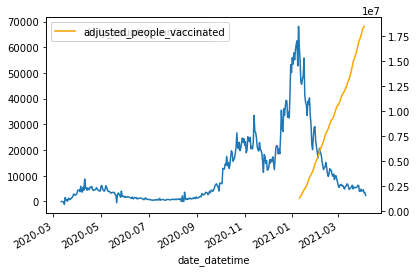

In [22]:
ax1 = df_pd_do.plot(x='date_datetime', y='daily_country_confirmed', logy=False)

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df_pd_do.plot(ax=ax2, x='date_datetime', y='adjusted_people_vaccinated', c='orange')

## New confirmed cases in the past week vs total vaccination

In [23]:
df_trend = df_pd_do.copy()

In [24]:
# Do a rolling sum to get the past week cases
# https://stackoverflow.com/questions/43787059/how-to-compute-cumulative-sum-of-previous-n-rows-in-pandas
df_trend['past_week_daily_cases'] = df_trend['daily_country_confirmed'].rolling(window=7, min_periods=7).mean()

In [25]:
df_trend['percent_people_vaccinated'] = df_trend['people_vaccinated']/df_trend['population']*100
df_trend['percent_total_vaccinations'] = df_trend['total_vaccinations']/df_trend['population']*100
df_trend['percent_adjusted_people_vaccinated'] = df_trend['adjusted_people_vaccinated']/df_trend['population']*100

In [26]:
df_trend['past_week_daily_cases_per_100k'] = df_trend['past_week_daily_cases']/df_trend['population']*100000

<AxesSubplot:xlabel='percent_adjusted_people_vaccinated'>

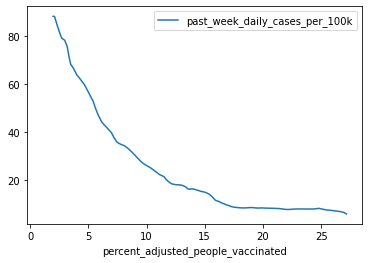

In [27]:
df_trend.plot(x='percent_adjusted_people_vaccinated', y='past_week_daily_cases_per_100k')
# df_trend.plot(x='percent_total_vaccinations', y='past_week_daily_cases_per_100k')


In [28]:
df_pd_do

,date_string,country_region,country_confirmed,location,population,continent,date_org,vaccine,total_vaccinations,people_vaccinated,people_fully_vaccinated,date_datetime,daily_country_confirmed,daily_confirmed_ewm_mean,adjusted_people_vaccinated
1271,2020-03-11,United Kingdom,1260.0,United Kingdom,67886004.0,Europe,NaN,NaN,NaN,NaN,NaN,2020-03-11,0.0,0.000000,NaN
1466,2020-03-14,United Kingdom,1141.0,United Kingdom,67886004.0,Europe,NaN,NaN,NaN,NaN,NaN,2020-03-14,-119.0,-66.111111,NaN
1555,2020-03-15,United Kingdom,3.0,United Kingdom,67886004.0,Europe,NaN,NaN,NaN,NaN,NaN,2020-03-15,-1138.0,-505.409836,NaN
1677,2020-03-16,United Kingdom,1550.0,United Kingdom,67886004.0,Europe,NaN,NaN,NaN,NaN,NaN,2020-03-16,1547.0,189.850949,NaN
1799,2020-03-17,United Kingdom,1953.0,United Kingdom,67886004.0,Europe,NaN,NaN,NaN,NaN,NaN,2020-03-17,403.0,253.257972,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73276,2021-04-01,United Kingdom,4359978.0,United Kingdom,67886004.0,Europe,2021-04-01,"Oxford/AstraZeneca, Pfizer/BioNTech",36277136.0,31318262.0,4958874.0,2021-04-01,4115.0,4710.572028,18138568.0
73468,2021-04-02,United Kingdom,4364543.0,United Kingdom,67886004.0,Europe,2021-04-02,"Oxford/AstraZeneca, Pfizer/BioNTech",36631187.0,31425682.0,5205505.0,2021-04-02,4565.0,4681.457623,18315593.5
73660,2021-04-03,United Kingdom,4367965.0,United Kingdom,67886004.0,Europe,2021-04-03,"Oxford/AstraZeneca, Pfizer/BioNTech",36904755.0,31523010.0,5381745.0,2021-04-03,3422.0,4429.566098,18452377.5
73852,2021-04-04,United Kingdom,4371389.0,United Kingdom,67886004.0,Europe,NaN,NaN,NaN,NaN,NaN,2021-04-04,3424.0,4228.452879,NaN


### past 7 days average daily case per 100k vs vaccination rates for different countries/region

In [154]:
curr_date_string = '2021-04-04'
curr_date = datetime.strptime(curr_date_string, '%Y-%m-%d')

prev_date = curr_date - timedelta(days=7)

print(curr_date)
print(prev_date)

2021-04-04 00:00:00
2021-03-28 00:00:00


In [155]:
df_case_vac = df_confirmed_loc_vac.copy()

In [156]:
df_case_vac['date'] = df_case_vac['date_string'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [157]:
# list_country = list(set(df_curr_case_vac['country_region'].to_list()))

In [158]:
# df_curr_case_vac = pd.DataFrame(columns=['country_region', 'date', 'past_week_daily_cases', 'total_vaccinations',
#                                          'people_vaccinated', 'people_fully_vaccinated', 'population'])

In [159]:
df_case_vac

,date_string,country_region,country_confirmed,location,population,continent,date_org,vaccine,total_vaccinations,people_vaccinated,people_fully_vaccinated,date
0,2020-01-22,Hong Kong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
1,2020-01-22,Japan,2.0,Japan,126476458.0,Asia,NaN,NaN,NaN,NaN,NaN,2020-01-22
2,2020-01-22,Macau,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
3,2020-01-22,Mainland China,547.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
4,2020-01-22,South Korea,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
...,...,...,...,...,...,...,...,...,...,...,...,...
74050,2021-04-05,Vietnam,2631.0,Vietnam,97338583.0,Asia,NaN,NaN,NaN,NaN,NaN,2021-04-05
74051,2021-04-05,West Bank and Gaza,251288.0,Palestine,5101416.0,Asia,NaN,NaN,NaN,NaN,NaN,2021-04-05
74052,2021-04-05,Yemen,4798.0,Yemen,29825968.0,Asia,NaN,NaN,NaN,NaN,NaN,2021-04-05
74053,2021-04-05,Zambia,88930.0,Zambia,18383956.0,Africa,NaN,NaN,NaN,NaN,NaN,2021-04-05


In [160]:
df_case_vac = df_case_vac.sort_values('date')

In [161]:
df_case_vac['daily_country_confirmed'] = df_case_vac.groupby('country_region')['country_confirmed'].diff()
df_case_vac['daily_country_confirmed'] = df_case_vac['daily_country_confirmed'].fillna(0)

In [162]:
df_case_vac['past_week_daily_cases'] = (df_case_vac.
                                             groupby('country_region')['daily_country_confirmed'].
                                             rolling(window=7, min_periods=7).mean().reset_index(0,drop=True))

In [165]:
df_temp = df_case_vac.dropna(subset=['people_vaccinated'])
list_countries_before_drop = list(df_confirmed_loc_vac['country_region'].unique())
list_countries_after_drop_null_ppl_vaccinated = list(df_temp['country_region'].unique())
df_case_vac_drop_null_total = df_confirmed_loc_vac.dropna(subset=['total_vaccinations'])
list_countries_after_drop_total_vac = list(df_case_vac_drop_null_total['country_region'].unique())

In [166]:
# countries that do not have values for people_vaccinated
list_country_no_ppl_vac = [x for x in list_countries_before_drop if x not in list_countries_after_drop_null_ppl_vaccinated]
# countires that do not have values for total_vaccinations
list_country_no_total_vac = [x for x in list_countries_before_drop if x not in list_countries_after_drop_total_vac]
# print(list_country_dropped)
# print(list_country_no_total_vac)

# countries that have total_vaccinations but no people_vaccinated
list_country_with_total_vac_no_ppl_vac = ([x for x in list_country_no_total_vac if x not in list_country_no_ppl_vac] +
                                          [x for x in list_country_no_ppl_vac if x not in list_country_no_total_vac])
print(list_country_with_total_vac_no_ppl_vac)
print(len(list_countries_after_drop_null_ppl_vaccinated))

['Nepal', 'Egypt', 'China', 'Algeria', 'Qatar', 'Saudi Arabia', 'Liechtenstein', 'Maldives', 'Mongolia', 'Antigua and Barbuda', 'Saint Vincent and the Grenadines']
135


In [167]:
# mat_total_vac = pd.isnull(df_curr_case_vac['total_vaccinations'])
# df_curr_case_vac = df_curr_case_vac[~mat_total_vac]

In [168]:
# Vaccine information
# https://www.bbc.com/news/world-asia-china-55212787
# Sinovac requires 2 doses
# Sputnik V requires 2 doses

In [169]:
# Calculate percentage of adjusted_people_vaccinated
# For countries/regions where people_vaccinated values are available:
# adjusted_people_vaccinated = 1*people_fully_vaccinated + 0.5*(people_vaccinated - people_fully_vaccinated)

df_case_vac['adjusted_people_vaccinated'] = np.nan

mat_ppl_vac = df_case_vac['country_region'].isin(list_countries_after_drop_null_ppl_vaccinated)

df_case_vac.loc[mat_ppl_vac, 'adjusted_people_vaccinated'] = \
(df_case_vac.loc[mat_ppl_vac, 'people_fully_vaccinated'].fillna(0) + 
 0.5*(df_case_vac.loc[mat_ppl_vac, 'people_vaccinated'].fillna(0) - 
      df_case_vac.loc[mat_ppl_vac, 'people_fully_vaccinated'].fillna(0)))

# For countries/regions where only total_vaccinations values (but not people_vaccinated) are available
# adjusted_people_vaccinated = 0.5*(total_vaccinations) # given that all vaccination brand used by these countries/regions require 2 doses
mat_total_vac = df_case_vac['country_region'].isin(list_country_with_total_vac_no_ppl_vac)
df_case_vac.loc[mat_total_vac, 'adjusted_people_vaccinated'] = \
0.5*df_case_vac.loc[mat_total_vac, 'total_vaccinations'].fillna(0)

In [183]:
df_case_vac_ppl_vac = df_case_vac[mat_ppl_vac].dropna(subset=['people_vaccinated'])
df_case_vac_total_vac = df_case_vac[mat_total_vac].dropna(subset=['total_vaccinations'])
df_case_vac = pd.concat([df_case_vac_ppl_vac, df_case_vac_total_vac])

In [184]:
df_case_vac

,date_string,country_region,country_confirmed,location,population,continent,date_org,vaccine,total_vaccinations,people_vaccinated,people_fully_vaccinated,date,daily_country_confirmed,past_week_daily_cases,adjusted_people_vaccinated,past_week_daily_cases_per_100k,percent_adjusted_people_vaccinated
52201,2020-12-13,United Kingdom,1835952.0,United Kingdom,6.788600e+07,Europe,2020-12-13,Pfizer/BioNTech,86465.0,86465.0,NaN,2020-12-13,21554.0,17938.571429,43232.5,26.424551,0.063684
52546,2020-12-15,Russia,2656601.0,Russia,1.459345e+08,Europe,2020-12-15,Sputnik V,28500.0,28500.0,NaN,2020-12-15,26902.0,27091.428571,14250.0,18.564106,0.009765
53257,2020-12-19,Israel,370152.0,Israel,8.655541e+06,Asia,2020-12-19,Pfizer/BioNTech,63.0,63.0,NaN,2020-12-19,2177.0,2411.857143,31.5,27.864892,0.000364
53545,2020-12-20,United Kingdom,2010080.0,United Kingdom,6.788600e+07,Europe,2020-12-20,Pfizer/BioNTech,675286.0,675286.0,NaN,2020-12-20,27249.0,24875.428571,337643.0,36.642941,0.497368
53547,2020-12-20,US,17766416.0,United States,3.294663e+08,North America,2020-12-20,Pfizer/BioNTech,556208.0,556208.0,NaN,2020-12-20,191894.0,217395.857143,278104.0,65.984250,0.084410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73811,2021-04-04,Qatar,182548.0,Qatar,2.881060e+06,Asia,2021-04-04,Pfizer/BioNTech,910851.0,NaN,NaN,2021-04-04,870.0,773.285714,455425.5,26.840320,15.807567
73788,2021-04-04,Mongolia,9598.0,Mongolia,3.278292e+06,Asia,2021-04-04,Oxford/AstraZeneca,376373.0,NaN,NaN,2021-04-04,0.0,415.000000,188186.5,12.659031,5.740382
73821,2021-04-04,Saudi Arabia,392009.0,Saudi Arabia,3.481387e+07,Asia,2021-04-04,"Oxford/AstraZeneca, Pfizer/BioNTech",4994576.0,NaN,NaN,2021-04-04,684.0,602.142857,2497288.0,1.729606,7.173257
73707,2021-04-04,China,102872.0,China,1.404676e+09,Asia,2021-04-04,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",139970000.0,NaN,NaN,2021-04-04,1073.0,172.714286,69985000.0,0.012296,4.982287


In [185]:
# df_curr_case_vac
df_case_vac['past_week_daily_cases_per_100k'] = (df_case_vac['past_week_daily_cases']/
                                                      df_case_vac['population']*100000)

df_case_vac['percent_adjusted_people_vaccinated'] = (df_case_vac['adjusted_people_vaccinated']/
                                                          df_case_vac['population']*100)

In [186]:
# Get the max date row with groupby after dropping rows that do not have total vaccications values
df_curr_case_vac = (df_case_vac[df_case_vac.
                                     groupby('country_region')['date'].
                                     transform('max') == df_case_vac['date']])

In [187]:
df_curr_case_vac

,date_string,country_region,country_confirmed,location,population,continent,date_org,vaccine,total_vaccinations,people_vaccinated,people_fully_vaccinated,date,daily_country_confirmed,past_week_daily_cases,adjusted_people_vaccinated,past_week_daily_cases_per_100k,percent_adjusted_people_vaccinated
55356,2020-12-30,Guinea,13688.0,Guinea,1.313279e+07,Africa,2020-12-30,Sputnik V,25.0,25.0,0.0,2020-12-30,0.0,15.714286,12.5,0.119657,0.000095
62448,2021-02-05,Burma,141104.0,Myanmar,5.440979e+07,Asia,2021-02-05,Oxford/AstraZeneca,380000.0,380000.0,NaN,2021-02-05,177.0,278.857143,190000.0,0.512513,0.349202
64869,2021-02-17,Mauritius,603.0,Mauritius,1.271767e+06,Africa,2021-02-17,Oxford/AstraZeneca,3843.0,3843.0,NaN,2021-02-17,2.0,1.285714,1921.5,0.101097,0.151089
65673,2021-02-21,Pakistan,571174.0,Pakistan,2.208923e+08,Asia,2021-02-21,"Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V",72882.0,72882.0,NaN,2021-02-21,1328.0,1163.571429,36441.0,0.526760,0.016497
65734,2021-02-22,Albania,100246.0,Albania,2.877800e+06,Europe,2021-02-22,Pfizer/BioNTech,6728.0,6073.0,655.0,2021-02-22,1184.0,1024.428571,3364.0,35.597629,0.116895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73811,2021-04-04,Qatar,182548.0,Qatar,2.881060e+06,Asia,2021-04-04,Pfizer/BioNTech,910851.0,NaN,NaN,2021-04-04,870.0,773.285714,455425.5,26.840320,15.807567
73788,2021-04-04,Mongolia,9598.0,Mongolia,3.278292e+06,Asia,2021-04-04,Oxford/AstraZeneca,376373.0,NaN,NaN,2021-04-04,0.0,415.000000,188186.5,12.659031,5.740382
73821,2021-04-04,Saudi Arabia,392009.0,Saudi Arabia,3.481387e+07,Asia,2021-04-04,"Oxford/AstraZeneca, Pfizer/BioNTech",4994576.0,NaN,NaN,2021-04-04,684.0,602.142857,2497288.0,1.729606,7.173257
73707,2021-04-04,China,102872.0,China,1.404676e+09,Asia,2021-04-04,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",139970000.0,NaN,NaN,2021-04-04,1073.0,172.714286,69985000.0,0.012296,4.982287


<AxesSubplot:xlabel='percent_adjusted_people_vaccinated', ylabel='past_week_daily_cases_per_100k'>

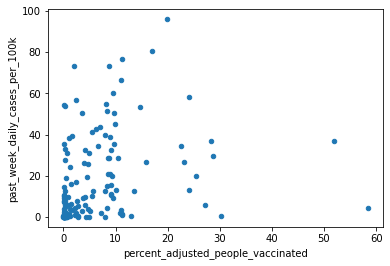

In [188]:
df_curr_case_vac.plot.scatter(x='percent_adjusted_people_vaccinated', y='past_week_daily_cases_per_100k')

In [175]:
# for c in list_country:
#     mat_c = df_confirmed_loc_vac['country_region'] == c
#     df_temp = df_confirmed_loc_vacp[mat_c].copy()
    
#     mat_t = (df_temp['date'] >= prev_date) & (df_temp['date'] <= curr_date)
#     df_temp = df_temp[mat_t].sort_values('date')
    
#     df_temp['past_week_daily_cases'] = df_temp['daily_country_confirmed'].rolling(window=7, min_periods=7).mean()

### Plotly (Dash) plots

In [176]:
from jupyter_dash import JupyterDash

In [177]:
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objects as go

In [178]:
x_col = 'percent_adjusted_people_vaccinated'
y_col = 'past_week_daily_cases'

In [179]:
df_curr_case_vac['country_confirmed_log'] = np.log10(df_curr_case_vac['country_confirmed'])
# df_curr_case_vac['past_week_daily_cases_test'] = df_curr_case_vac['past_week_daily_cases']/10


In [180]:
df_curr_case_vac['continent'].unique()

array(['Asia', 'Africa', 'North America', 'Europe', 'Oceania',
       'South America'], dtype=object)

In [181]:
# x = df_curr_case_vac[x_col]
# y = df_curr_case_vac[y_col]
# country_region = df_curr_case_vac['country_region']

# country_region = df_curr_case_vac['country_region']
# date_used = df_curr_case_vac['date_string']

In [189]:
# https://plotly.com/python/hover-text-and-formatting/#advanced-hover-template
# https://community.plotly.com/t/hover-data-on-go-scatter-and-or-shared-legends-with-plotly-express/34239
fig_case_vac = go.Figure()

if y_col == 'past_week_daily_cases_per_100k':
    past_week_string = 'Past week daily average case per 100k'
else:
    past_week_string = 'Past week daily average'

for continent_name, continent in df_curr_case_vac.groupby('continent'):
    fig_case_vac.add_traces(go.Scatter(x=continent[x_col],
                                       y=continent[y_col],
                                       mode='markers',
                                       hoveron='points',
                                       text=continent['country_region'],
                                       customdata=continent['date_string'],
                                       hovertemplate= 
                                       "Country: %{text}<br>" +
                                       "Date: %{customdata}<br>" +
                                       past_week_string + ": %{y: .0f}<br>" +
                                       "Percent adjusted people vaccinated: %{x: .2f}%<br>" +
                                       "<extra></extra>",
                                       name=continent_name)
                           )

# Change marker size
fig_case_vac.update_traces(marker=dict(size=12,
                              opacity=0.8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
    
# Turn background to transparent
fig_case_vac.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

# Turn on x-axis and y-axis lines
fig_case_vac.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks="inside")
# Title
fig_case_vac.update_xaxes(title_text='Adjusted people vaccinated (%)')
# Range
# fig.update_xaxes(range=[df_curr_case_vac[x_col].min() - 2, df_curr_case_vac[x_col].max() + 2])


fig_case_vac.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks="inside")
if y_col == 'past_week_daily_cases_per_100k':
    fig_case_vac.update_yaxes(title_text='Past week daily average cases (per 100K people)')
else:
    fig_case_vac.update_yaxes(title_text='Past week daily average cases (number of people)')
    
fig_case_vac.show()
# 
# 

#### Country's cases over different vaccination rate

In [195]:
# https://plotly.com/python/hover-text-and-formatting/#advanced-hover-template
# https://community.plotly.com/t/hover-data-on-go-scatter-and-or-shared-legends-with-plotly-express/34239
fig_case_vac_ts = go.Figure()

# list_country = ['United Kingdom', 'Israel', 'US', 'Australia', 'China']
list_country = ['United Kingdom']

x_col = 'percent_adjusted_people_vaccinated'
y_col = 'past_week_daily_cases'




if y_col == 'past_week_daily_cases_per_100k':
    past_week_string = 'Past week daily average case per 100k'
else:
    past_week_string = 'Past week daily average'

for country in list_country:
    mat_country = df_case_vac['country_region'] == country
    df_case_vac_ts = df_case_vac[mat_country]
    fig_case_vac_ts.add_traces(go.Scatter(x=df_case_vac_ts[x_col],
                                       y=df_case_vac_ts[y_col],
                                       mode='lines+markers',
                                       hoveron='points',
                                       text=df_case_vac_ts['date_string'],
                                       hovertemplate= 
                                       "Date: %{text}<br>" +
                                       past_week_string + ": %{y: .0f}<br>" +
                                       "Percent adjusted people vaccinated: %{x: .2f}%<br>" +
                                       "<extra></extra>",
                                       name=country)
                           )

# # Change marker size
# fig_case_vac_one_country.update_traces(marker=dict(size=12,
#                               opacity=0.8,
#                               line=dict(width=2,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))
    
# # Turn background to transparent
fig_case_vac_ts.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

# Turn on x-axis and y-axis lines
fig_case_vac_ts.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks="inside")
# Title
fig_case_vac_ts.update_xaxes(title_text='Adjusted people vaccinated (%)')
# # Range
# # fig.update_xaxes(range=[df_curr_case_vac[x_col].min() - 2, df_curr_case_vac[x_col].max() + 2])


fig_case_vac_ts.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks="inside")
if y_col == 'past_week_daily_cases_per_100k':
    fig_case_vac_ts.update_yaxes(title_text='Past week daily average cases (per 100K people)')
else:
    fig_case_vac_ts.update_yaxes(title_text='Past week daily average cases (number of people)')
    
fig_case_vac_ts.show()
# 
# 

In [72]:
# Vaccine information
# https://www.bbc.com/news/world-asia-china-55212787
# Sinovac requires 2 doses
# Sputnik V requires 2 doses

df_temp['vaccine'].unique()

array([nan, 'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac',
       'Pfizer/BioNTech', 'Sinopharm/Beijing', 'Oxford/AstraZeneca',
       'Sputnik V', 'Moderna, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinopharm/Beijing'], dtype=object)

In [76]:
df_temp.drop_duplicates(subset=['country_region', 'vaccine'], keep='last')

,date_string,country_region,country_confirmed,location,population,continent,date_org,vaccine,total_vaccinations,people_vaccinated,people_fully_vaccinated
61311,2021-01-30,Egypt,164871.0,Egypt,1.023344e+08,Africa,2021-01-30,Sinopharm/Beijing,1315.0,NaN,NaN
64711,2021-02-16,Saudi Arabia,373046.0,Saudi Arabia,3.481387e+07,Asia,2021-02-16,Pfizer/BioNTech,462812.0,NaN,NaN
65147,2021-02-19,Algeria,111418.0,Algeria,4.385104e+07,Africa,2021-02-19,Sputnik V,75000.0,NaN,NaN
70722,2021-03-19,Nepal,275625.0,Nepal,2.913681e+07,Asia,2021-03-19,Oxford/AstraZeneca,1600000.0,NaN,NaN
71756,2021-03-25,Antigua and Barbuda,1080.0,Antigua and Barbuda,9.792800e+04,North America,2021-03-25,Oxford/AstraZeneca,26424.0,NaN,NaN
72089,2021-03-26,Saint Vincent and the Grenadines,1715.0,Saint Vincent and the Grenadines,1.109470e+05,North America,2021-03-26,Oxford/AstraZeneca,10519.0,NaN,NaN
73196,2021-04-01,Liechtenstein,2670.0,Liechtenstein,3.813700e+04,Europe,2021-04-01,"Moderna, Pfizer/BioNTech",6100.0,NaN,NaN
73586,2021-04-03,Maldives,24548.0,Maldives,5.405420e+05,Asia,2021-04-03,Oxford/AstraZeneca,243749.0,NaN,NaN
73707,2021-04-04,China,102872.0,China,1.404676e+09,Asia,2021-04-04,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",139970000.0,NaN,NaN
73724,2021-04-04,Egypt,204256.0,Egypt,1.023344e+08,Africa,2021-04-04,"Oxford/AstraZeneca, Sinopharm/Beijing",148987.0,NaN,NaN


#### Plotly express plot

In [ ]:
# https://stackoverflow.com/questions/62825101/plotly-graph-objects-add-df-column-to-hovertemplate
# if y_col == 'past_week_daily_cases_per_100k':
#     logy=False
# else:
#     logy=True
logy=False

fig = px.scatter(df_curr_case_vac,
                 x=x_col,
                 y=y_col,
                 color='continent',
                 hover_name="country_region",
                 hover_data={x_col:True, y_col:True, 'date_string':True},
                 log_y=logy)

# text='country_region',
# log_x=True
# log_y=True

# size='country_confirmed',
# size='country_confirmed_log',

# Change marker size
fig.update_traces(marker=dict(size=12,
                              opacity=0.8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

scatter = fig.data[0]

# Change the location of country label
pos_y = 'middle'
pos_x = 'right'
fig.update_traces(textposition='{} {}'.format(pos_y, pos_x))

# marker = dict(size=8, color=list(map(SetColor, df_curr_case_vac['continent']))),

# Turn background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)'})

# Turn on x-axis and y-axis lines
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks="inside")
# Title
fig.update_xaxes(title_text='Adjusted people vaccinated (%)')
# Range
# fig.update_xaxes(range=[df_curr_case_vac[x_col].min() - 2, df_curr_case_vac[x_col].max() + 2])


fig.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks="inside")
if y_col == 'past_week_daily_cases_per_100k':
    fig.update_yaxes(title_text='Past week daily average cases (per 100K people)')
else:
    fig.update_yaxes(title_text='Past week daily average cases (number of people; log scale)')
# fig.update_yaxes(range=[df_curr_case_vac[y_col].min() - 2, df_curr_case_vac[y_col].max() + 2])

fig.show()

In [372]:
# fig_case_vac.add_traces(go.Scatter(x=x,
#                                    y=y,
#                                    mode='markers',
#                                    hoveron='points',
#                                    hovertemplate= 
#                                    "Country: {}<br>".format(country_region) +
#                                    "Date: {}<br>".format(date_used) +
#                                    "Past week daily average case per 100k: %{y}<br>" +
#                                    "Percent adjusted people vaccinated: %{x}<br>" +
#                                    "<extra></extra>",
#                                    name='country_region')
#                        )

In [ ]:
# fig_case_vac.add_traces(go.Scatter(x=x,
#                                        y=y,
#                                        mode='markers',
#                                        hoveron='points',
#                                        hovertemplate= 
#                                        "Country: {}<br>".format(country) +
#                                        "Date: {}<br>".format(group['date_string']) +
#                                        "Past week daily average case per 100k: %{y}<br>" +
#                                        "Percent adjusted people vaccinated: %{x}<br>" +
#                                        "<extra></extra>",
#                                        name='country_region')
#                            )
